In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam

# Set parameters
base_dir = r'C:\Users\adity\Downloads\lab2_dataset\lab2_dataset'
img_height, img_width = 150, 150
batch_size = 32
num_classes = 4 # Update based on your classes

In [3]:
# Load dataset
classes = ['smokefire','smoke','nofire','fire']
data = []
labels = []
for label in classes:
    folder_path = os.path.join(base_dir, label)
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(folder_path, filename)
            img = load_img(img_path, target_size=(img_height, img_width))
            img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
            data.append(img_array)
            labels.append(classes.index(label))

data = np.array(data)
labels = np.array(labels)


In [4]:
print(f"Data shape: {data.shape}")
print(f"Labels shape: {labels.shape}")


Data shape: (800, 150, 150, 3)
Labels shape: (800,)


In [6]:

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [7]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model

# Load MobileNet model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = True  # Unfreeze the entire model initially

# Add custom layers on top of MobileNet
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)  # Increased layer size
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)  # Additional dense layer
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)


C:\Users\adity\AppData\Local\Temp\ipykernel_21396\983483335.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 11s 1us/step


In [8]:
# Create final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model with a lower learning rate
optimizer = Adam(learning_rate=1e-4)  # Lower learning rate
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train model
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=50,  # Increased epochs
                    verbose=1)

c:\Users\adity\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.2731 - loss: 2.9824 - val_accuracy: 0.6187 - val_loss: 0.9356
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.4398 - loss: 1.5713 - val_accuracy: 0.6938 - val_loss: 0.6909
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5028 - loss: 1.2235 - val_accuracy: 0.8125 - val_loss: 0.5332
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6056 - loss: 1.0733 - val_accuracy: 0.8250 - val_loss: 0.4833
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.6442 - loss: 0.8929 - val_accuracy: 0.8500 - val_loss: 0.3905
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.6515 - loss: 0.9026 - val_accuracy: 0.8500 - val_loss: 0.3805
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6564 - loss: 0.8826 - val_accuracy: 0.8750 - val_loss: 0.2979
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6951 - loss: 0.7563 - val_accuracy: 0.8750 - val_loss:

In [9]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Loss: {loss:.4f}")


Validation Accuracy: 0.9125
Validation Loss: 0.4471


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 362ms/step
Classification Report:
              precision    recall  f1-score   support

   smokefire       0.78      1.00      0.88        40
       smoke       1.00      0.75      0.86        40
      nofire       0.97      0.95      0.96        40
        fire       0.95      0.95      0.95        40

    accuracy                           0.91       160
   macro avg       0.93      0.91      0.91       160
weighted avg       0.93      0.91      0.91       160



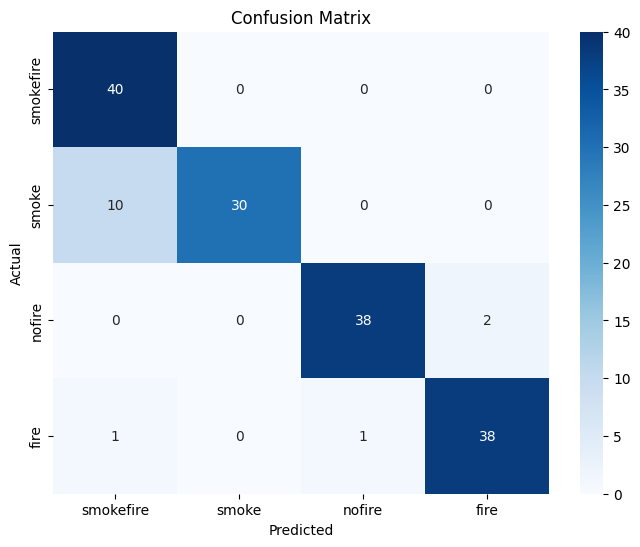

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict the labels for the validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate classification report
print("Classification Report:")
print(classification_report(y_val, y_pred_classes, target_names=classes))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


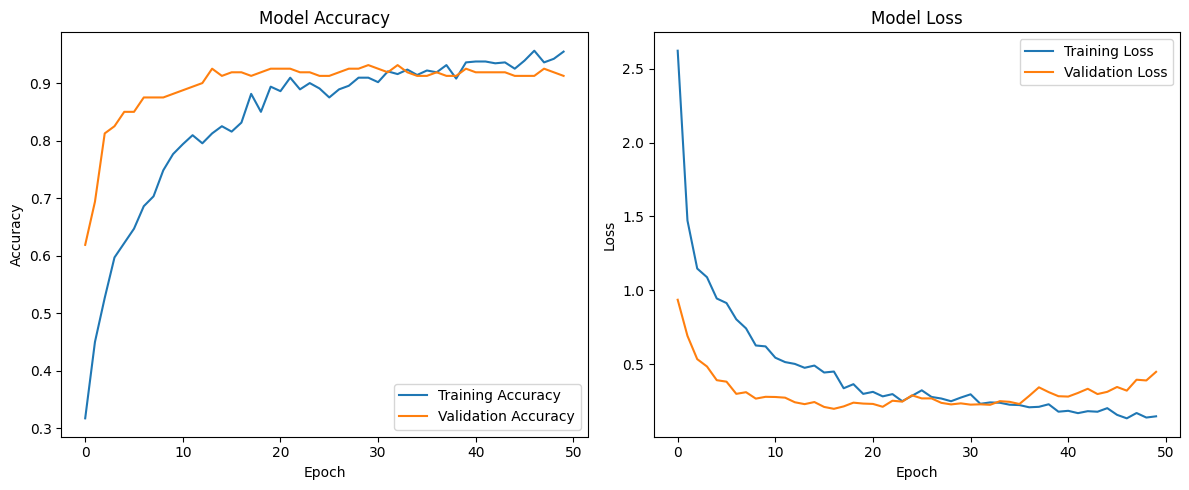

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


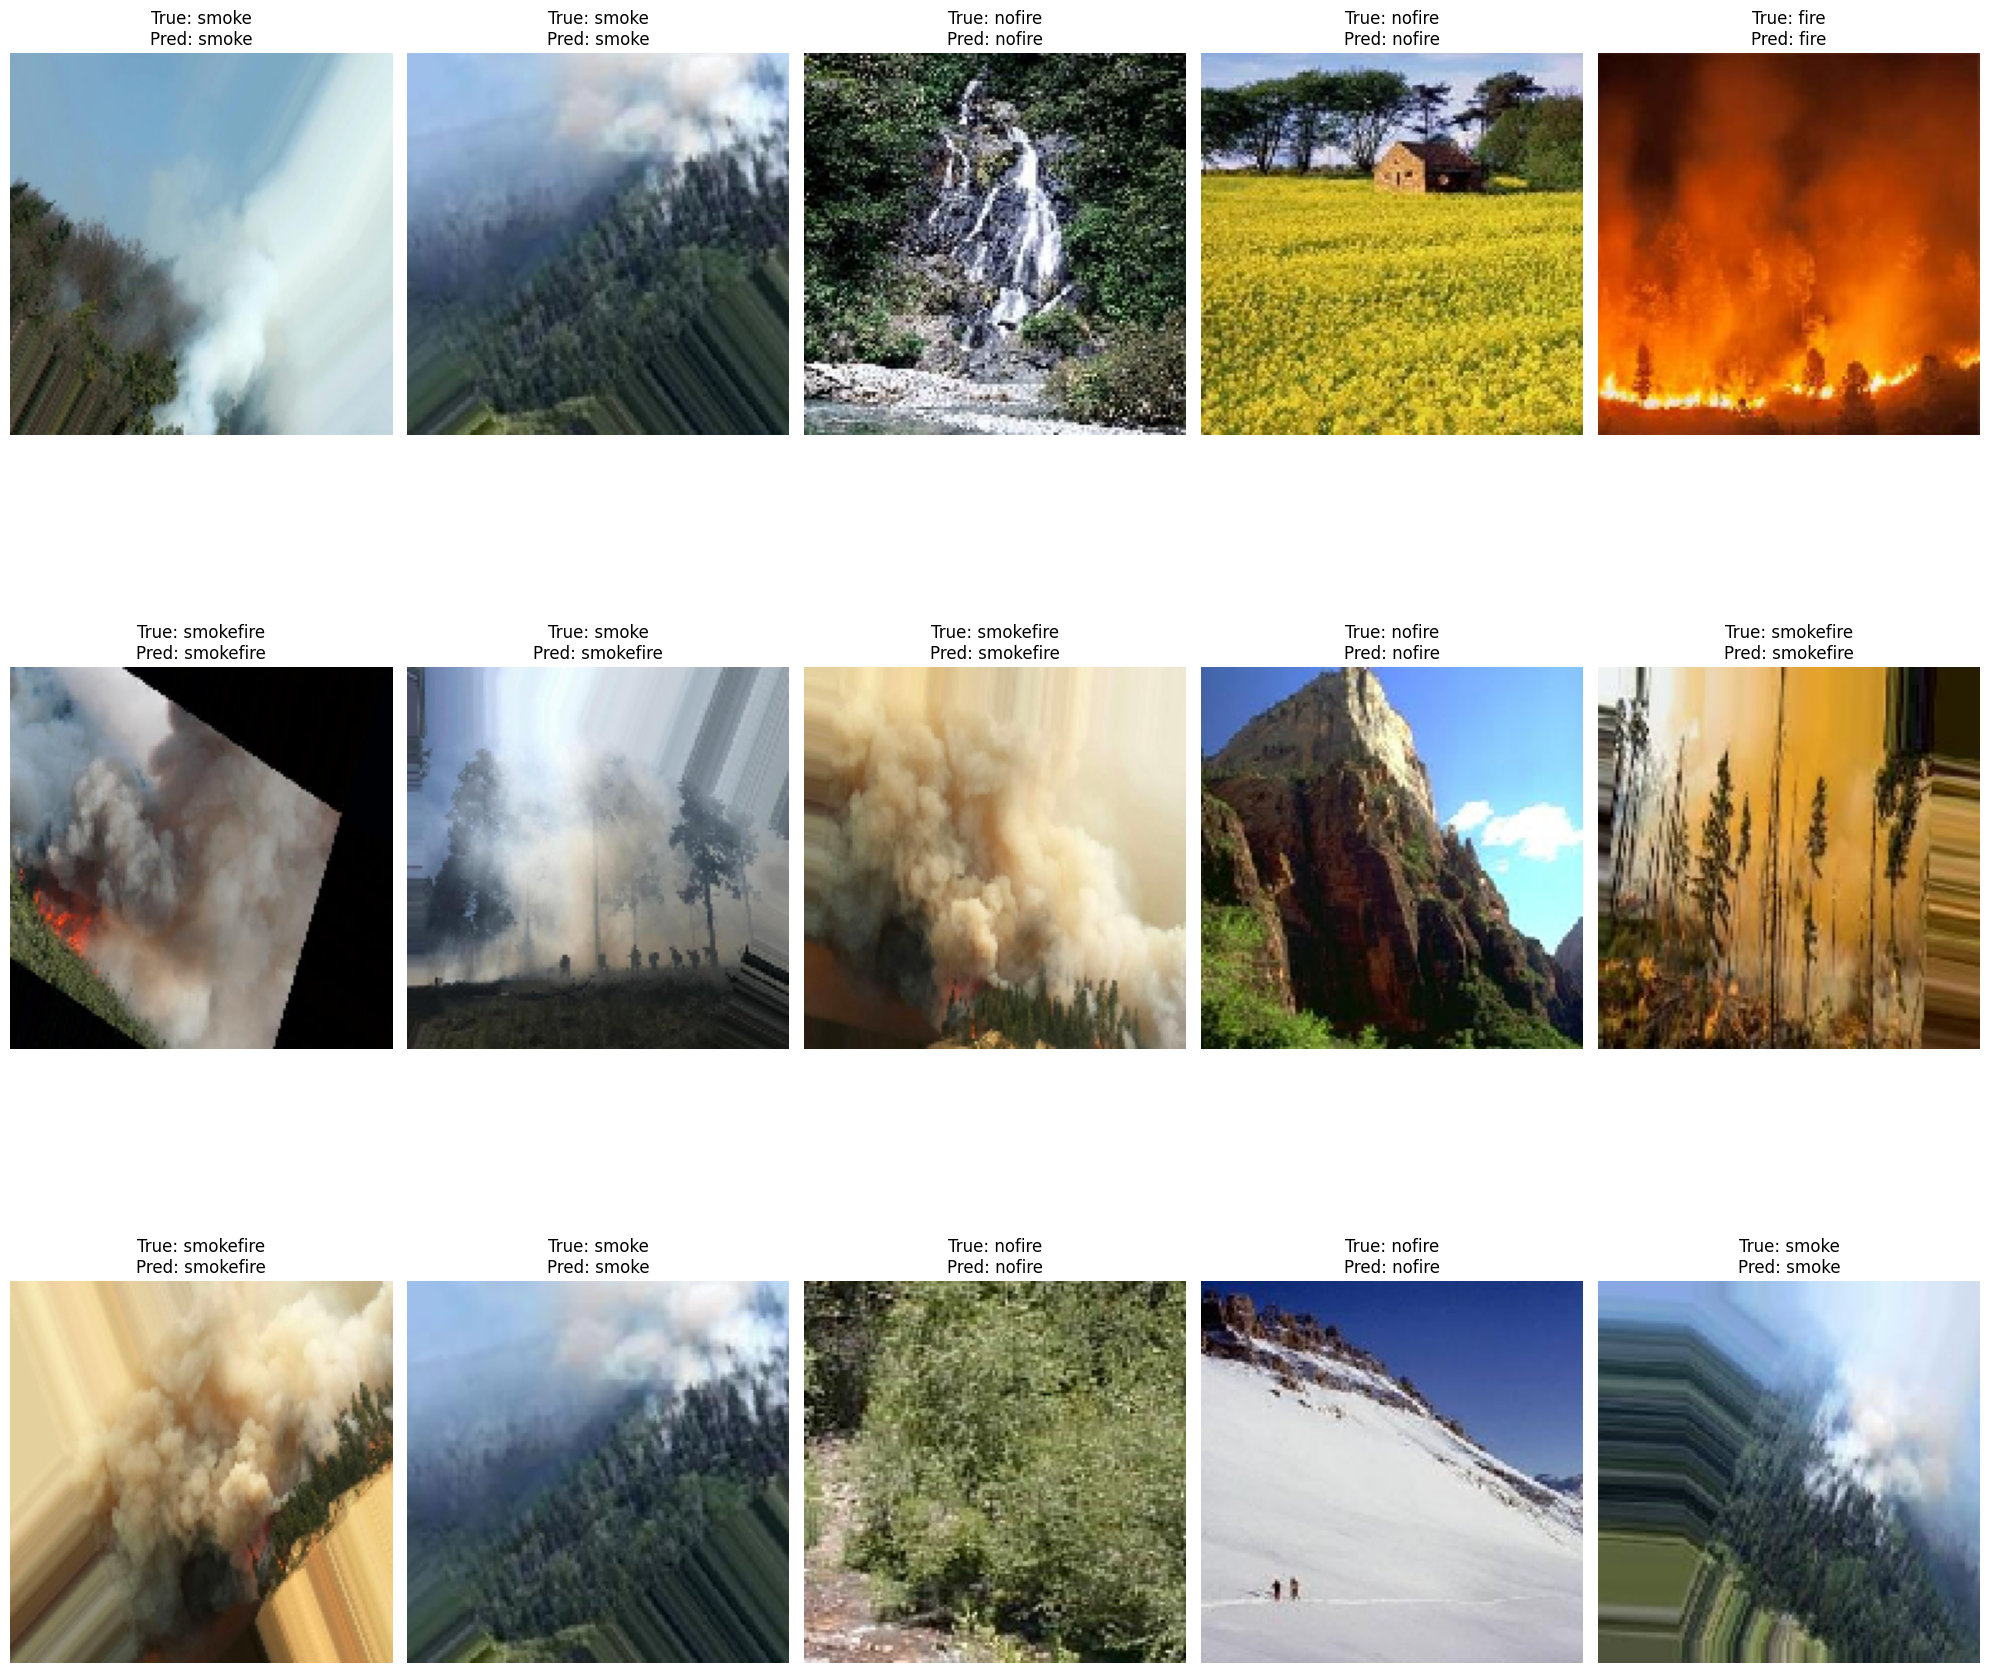

In [12]:
import random
import matplotlib.pyplot as plt

# Function to predict and visualize random images
def predict_and_visualize_random_images(base_dir, model, img_height, img_width, classes, num_images=15):
    # Select random images from the base directory
    random_images = []
    for _ in range(num_images):
        random_class = random.choice(classes)
        folder_path = os.path.join(base_dir, random_class)
        random_file = random.choice(os.listdir(folder_path))
        img_path = os.path.join(folder_path, random_file)
        random_images.append((img_path, random_class))

    # Plot the images with predictions
    plt.figure(figsize=(20, 20))
    for i, (img_path, true_class) in enumerate(random_images):
        # Load and preprocess the image
        img = load_img(img_path, target_size=(img_height, img_width))
        img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Predict the class
        prediction = model.predict(img_array)
        predicted_class = classes[np.argmax(prediction)]

        # Display the image with true and predicted labels
        plt.subplot(3, 5, i + 1)  # 3 rows, 5 columns
        plt.imshow(img)
        plt.title(f"True: {true_class}\nPred: {predicted_class}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to visualize 15 predictions
predict_and_visualize_random_images(base_dir, model, img_height, img_width, classes, num_images=15)


In [13]:
import os
print("Model successfully converted and saved as model.tflite.")
print("Current Working Directory:", os.getcwd())


Model successfully converted and saved as model.tflite.
Current Working Directory: c:\Users\adity\Downloads


In [14]:
model.save('hello.keras')

In [15]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model to a .tflite file
with open("model.tflite", 'wb') as f:
    f.write(tflite_model)

print("Model successfully converted and saved as model.tflite.")

INFO:tensorflow:Assets written to: C:\Users\adity\AppData\Local\Temp\tmpvblblwwb\assets


INFO:tensorflow:Assets written to: C:\Users\adity\AppData\Local\Temp\tmpvblblwwb\assets


Saved artifact at 'C:\Users\adity\AppData\Local\Temp\tmpvblblwwb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2621384683216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2621384685136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2621384684176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2621384685904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2621384682832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2621384685520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2621384684944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2621384684368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2621384683792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2621384686480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  26213

In [22]:
pip install lime


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283843 sha256=8d15f66e318f95fc5b358ba46157d753b0ead804dd75a31d3928610a9a961dfc
  Stored in directory: c:\users\adity\appdata\local\pip\cache\wheels\85\fa\a3\9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


Found 800 images belonging to 1 classes.


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━

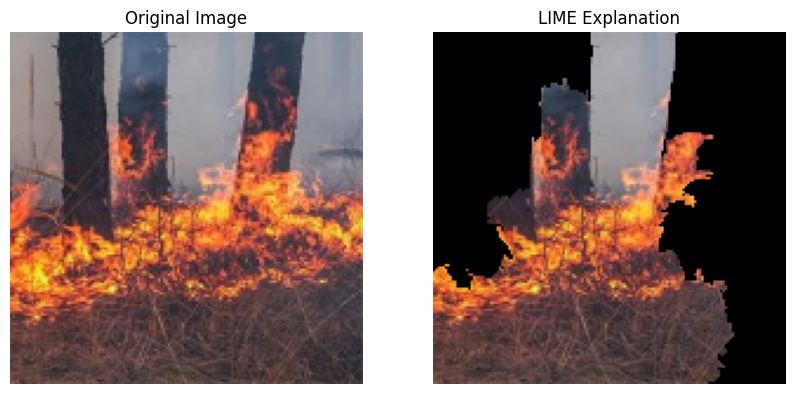

In [30]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from lime import lime_image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model


def load_model(filename=r"C:\Users\adity\Downloads\hello.keras"):
    return tf.keras.models.load_model(filename, compile=False)

loaded_model = load_model()
loaded_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])

model = loaded_model

def general_preprocessing(img):
    # Normalize the image (adjust if your model needs different preprocessing)
    return img / 255.0  # Adjust according to model requirements (e.g., scaling, normalization)

# Generalized ImageDataGenerator for any model
testpath = r"C:\Users\adity\Downloads\lab2_dataset"

testbatch = ImageDataGenerator(preprocessing_function=general_preprocessing).flow_from_directory(
    directory=testpath,
    target_size=(model.input_shape[1], model.input_shape[2]),  # Dynamically set the target size based on model input
    batch_size=30,
    shuffle=False,
    class_mode='categorical'
)



testbatch = testbatch

# Choose a random image from the test set
random_index = np.random.randint(0, len(testbatch.filepaths))
img_path = testbatch.filepaths[random_index]
img = cv2.imread(img_path)

# Resize image to fit the model's expected input shape, if needed
input_size = (model.input_shape[1], model.input_shape[2])
img = cv2.resize(img, input_size)

# General preprocessing: Customize this part based on the model's expected input preprocessing
img_preprocessed = img.copy().astype(np.float32) / 255.0  # Adjust based on your model's needs

# Create a LIME explainer for image classification
explainer = lime_image.LimeImageExplainer()

# Define the function to predict probabilities using the model
def predict_proba(images):
    return model.predict(images)

# Explain the model's prediction for the chosen image
explanation = explainer.explain_instance(
    img_preprocessed.astype('double'),
    predict_proba,
    top_labels=1,  # Number of labels to explain
    hide_color=0,  # Color for areas not covered by the mask
    num_samples=1000  # Number of samples to generate for explanation
)

# Get the explanation for the top label
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=False,
    num_features=5,  # Number of superpixels to include in explanation
    hide_rest=False
)

# Overlay the explanation onto the original image
marked_img = img.copy()
marked_img[mask == 0] = 0  # Zero out areas not covered by the mask

# Display the original image and the LIME explanation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(marked_img, cv2.COLOR_BGR2RGB))
plt.title('LIME Explanation')
plt.axis('off')
plt.show()